## Import dependencies

In [728]:
from calendar import monthrange
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder

## Load training data frame

In [729]:
df_train = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")

In [730]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99071 entries, 0 to 99070
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(42), object(59)
memory usage: 80.1+ MB


In [731]:
df_train.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,VARIANT,MILEAGE,OPERATING_HOURS,MILAGE_IN_FIELD,MILAGE_SALES,OPERATING_HOURS_SALES,RIM_KEY,COLOR_CODE,COLOR_CODE_NAME,COLOR,COLOR_TYPE,UPHOLSTERY_CODE,UPHOLSTERY,UPHOLSTERY_CODE_ALT,CERTIFICATE_TYPE,CERTIFICATE_TYPE_DATE,FACTORY_NUMBER,ENGINE_ID,ENGINE_TYPE,ENGINE_ID_ALT,TRANSMISSION,TRANSMISSION_TYPE,TRANSMISSION_ID,TRANSMISSION_SHORT,TRANSMISSION_NAME,RIMS,FRONT_TIRES,FRONT_TIRES_CONDITION,REAR_TIRES,REAR_TIRES_CONDITION,...,KAT_VEHICLE,FUEL_TYPE,FUEL_TYPE_NAME,DRIVE_TYPE,DRIVE_TYPE_NAME,VEHICLE_MODEL_ID,VEHICLE_MODEL_ID_NAME,COMMISSION_TYPE,COMMISSION_TYPE_NAME,DEMONSTRATION_STATUS,PURCHASE_DATE,PURCHASE_BOOKING_DATE,PURCHASE_MILAGE,PURCHASE_OPERATION_HOURS,PRICE_LIST,DAY_OF_REGISTRATION,AT_LOCATION_SINCE,LAID_UP_TIME,SOLD_CUSTOMER_ID,SOLD_INVOICE_COSTUMER_ID,MILAGE_SALE,OPERATION_HOURS_SALE,SOLD_INVOICE_COSTUMER_ID2,CUSTOMER_TYPE,CUSTOMER_GROUP,CUSTOMER_GROUP_NAME,CUSTOMER_FEATURE,CUSTOMER_FEATURE_NAME,SALE_CUSTOMER_ID2,CUSTOMER_SALE_GROUP,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,NaN,8600.0,0.0,1.0,8600.0,0.0,NaN,NaN,Nicht definiert,Magnetic-Grau Metallic,N,NaN,Teilleder,N,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Handschaltung,NaN,NaN,0.0,NaN,0.0,...,1,1,Bleifrei,N,Nicht definiert,0.0,Keine Zuteilung,2,Gebrauchtwagen,NaN,2024-02-29,2024-02-29,8600.0,0.0,15990,NaN,0.0,7.0,C38451,C38451,8600.0,0.0,C38451,K,EVPR,EV privat,EVPR,Endverbraucher private,C38451,EVPR,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,NaN,0.0,0.0,1.0,0.0,0.0,NaN,717,Nicht definiert,Onyx Schwarz-Metallic,N,R7C0,Grau,N,NaN,0.0,NaN,5363376,4 Zylinder Reihe-Mot,NaN,NaN,7 Gang Automatik-Get,NaN,Z,Automatic,NaN,NaN,0.0,NaN,0.0,...,N,9,Andere,1,Vorderrad,5.0,Gelaendewagen/Pickup,1,Neuwagen,NaN,2024-07-03,2024-07-04,0.0,0.0,NaN,NaN,0.0,23.0,493187,40963,0.0,0.0,40963,K,GROS,Grossabnehmer,GROS,Grossabnehmer,493187,NaN,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,NaN,1297.0,0.0,1.0,0.0,0.0,NaN,NaN,Nicht definiert,Ink Black Metallic,N,NaN,siehe Ausstattung,N,NaN,0.0,NaN,NaN,2.0 TDE 66KW/90 E4,C3,NaN,NaN,NaN,Y,Handschaltung,NaN,NaN,0.0,NaN,0.0,...,N,3,Diesel,N,Nicht definiert,4.0,Van/Kleinbus,1,Neuwagen,NaN,2024-05-23,2024-05-23,0.0,0.0,44462.2,N,0.0,13.0,553344,496814,0.0,0.0,496814,K,GROS,Grossabnehmer,GROS,Grossabnehmer,553344,EVPR,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,NaN,6020.0,0.0,1.0,6020.0,0.0,NaN,8E8E,Nicht definiert,Reflexsilber Metallic,N,EL,Titanschwarz/Titanschwarz,N,NaN,0.0,NaN,NaN,DSGD,NaN,V,UVN,NaN,N,Nicht definiert,NaN,NaN,0.0,NaN,0.0,...,N,N,Andere,N,Nicht definiert,0.0,Keine Zuteilung,1,Neuwagen,NaN,2023-07-13,2023-07-13,0.0,0.0,NaN,NaN,0.0,1.0,50,50,81.0,0.0,50,U,INT,Interne Kunden,INT,Interne Kunden,50,INT,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,NaN,0.0,0.0,1.0,0.0,0.0,NaN,PN4GM,Nicht definiert,Agate Black Metallic -(PN,N,11UZ7,Stoffpolsterung in Anthra,N,NaN,0.0,NaN,NaN,BITTE MOT-ID PFLEGEN,*,NaN,6-Gang-Schaltgetrieb,NaN,N,Nicht definiert,NaN,NaN,0.0,NaN,0.0,...,N,9,Andere,N,Nicht 

## Split train and test set

In [732]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.2, random_state=0)

## Data frame preparation

### Manual dtype correction

In [733]:
dtypes = {
    "date": "datetime64[ns]",
    "num": np.float64,
    "str": pd.StringDtype(),
}

columns_of_interest = {
    # "RPAKREP_VEHICLE_HKEY": "str",
    "COMPANY": "str",
    "OFFICE": "str",
    "OFFICE_MAIN_BRAND": "str",
    "CHASSIS_NUMBER": "str",
    "MANUFACTURER_SHORT": "str",
    "MANUFACTURER": "str",
    "VEHICLE_GROUP": "str",
    "VEHICLE_TYPE": "str",
    "MODEL_CODE": "str",
    "VARIANT": "str",
    "MILEAGE": "num",
    "OPERATING_HOURS": "num",
    "MILAGE_IN_FIELD": "num",
    "MILAGE_SALES": "num",
    "OPERATING_HOURS_SALES": "num",
    # "RIM_KEY": "str",
    "COLOR_CODE": "str",
    "COLOR_CODE_NAME": "str",
    "COLOR": "str",
    "COLOR_TYPE": "str",
    "UPHOLSTERY_CODE": "str",
    "UPHOLSTERY": "str",
    "UPHOLSTERY_CODE_ALT": "str",
    # "CERTIFICATE_TYPE": "str",
    # "CERTIFICATE_TYPE_DATE": "num",
    "FACTORY_NUMBER": "str",
    "ENGINE_ID": "str",
    "ENGINE_TYPE": "str",
    "ENGINE_ID_ALT": "str",
    "TRANSMISSION": "str",
    "TRANSMISSION_TYPE": "str",
    "TRANSMISSION_ID": "str",
    "TRANSMISSION_SHORT": "str",
    "TRANSMISSION_NAME": "str",
    "RIMS": "str",
    "FRONT_TIRES": "str",
    # "FRONT_TIRES_CONDITION": "num",
    "REAR_TIRES": "str",
    # "REAR_TIRES_CONDITION": "num",
    "NUMBER_DOORS": "num",
    "NUMBER_SEATS": "num",
    "PERMITTED_TOTAL_WEIGHT": "num",
    "MAX_TRAILOR_LOAD": "num",
    "CURB_WEIGHT": "num",
    "YEAR_CONSTRUCTION": "num",
    "CONSTRUCTION_MONTH": "num",
    "NUMBER_AXLE": "num",
    "NUMBER_ENGINE_CYLINDER": "num",
    # "REPAIR_RKZ": "num",
    # "OPTICAL_CONDITION": "num",
    # "TECHNICAL_CONDITION": "num",
    "ACCIDENT_VEHICLE": "str",
    # "COMMISSION_NUMBER": "str",
    "HORSEPOWER": "num",
    "KW": "num",
    "CCM": "num",
    "NUMBER_OWNERS": "num",
    "IS_USED_CAR": "num",
    "LEASING_CONTRACT_DATE": "date",
    "LEASING_START": "date",
    "LEASING_END": "date",
    "LEASING_MILAGE": "num",
    # "PAINT_TYPE": "str",
    "FINANCING_TYPE": "str",
    "FINANCING_TYPE_NAME": "str",
    "KAT_VEHICLE": "str",
    "FUEL_TYPE": "str",
    "FUEL_TYPE_NAME": "str",
    "DRIVE_TYPE": "str",
    "DRIVE_TYPE_NAME": "str",
    "VEHICLE_MODEL_ID": "str",
    "VEHICLE_MODEL_ID_NAME": "str",
    "COMMISSION_TYPE": "str",
    "COMMISSION_TYPE_NAME": "str",
    "DEMONSTRATION_STATUS": "str",
    "PURCHASE_DATE": "date",
    "PURCHASE_BOOKING_DATE": "date",
    "PURCHASE_MILAGE": "num",
    # "PURCHASE_OPERATION_HOURS": "num",
    "PRICE_LIST": "num",
    # "DAY_OF_REGISTRATION": "str",
    "AT_LOCATION_SINCE": "num",
    "LAID_UP_TIME": "num",
    "SOLD_CUSTOMER_ID": "str",
    "SOLD_INVOICE_COSTUMER_ID": "str",
    "MILAGE_SALE": "num",
    # "OPERATION_HOURS_SALE": "num",
    # "SOLD_INVOICE_COSTUMER_ID2": "str",
    "CUSTOMER_TYPE": "str",
    # "CUSTOMER_GROUP": "str",
    # "CUSTOMER_GROUP_NAME": "str",
    "CUSTOMER_FEATURE": "str",
    "CUSTOMER_FEATURE_NAME": "str",
    # "SALE_CUSTOMER_ID2": "str",
    # "CUSTOMER_SALE_GROUP": "str",
    # "CUSTOMER_SALE_GROUP_NAME": "str",
    "CUSTOMER_SALE_GROUP2": "str",
    "CUSTOMER_SALE_GROUP2_NAME": "str",
    "SCALED_CURRENT_VALUE": "num",
    "SCALED_INVENTURAL_VALUE": "num",
    "SCALED_REPORT_VALUE": "num",
    # "SCALED_VALUATION_PRICE": "num",
    "SCALED_GUIDE_PRICE": "num",
    "SCALED_TOTAL_SALES_PRICE_BASIS": "num",
    "SCALED_TOTAL_SALE_PRICE": "num",
}


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    return df[columns_of_interest.keys()]\
        .astype({k: dtypes[v] for k, v in columns_of_interest.items()})

### Map specific features values

In [734]:
color_mapping = {
    "white": ["WeiÃŸ", "weiß", "weiÃƒ?", "weiss", "white", "bianco", "blanco", "pearl", "snow"],
    "silver": ["silber", "silver", "magnetic sil", "tridion", "hightechsilb"],
    "black": ["schwar", "blac", "obsidian", "nera"],
    "orange": ["orange"],
    "blue": ["blau", "blue", "bleu", "tansanitbl"],
    "red": ["rot", "red", "rosso", "rojo", "tokio fusion", "tokyo fusion", "peperoncino", "bordeaux"],
    "violet": ["violet", "lila", "magenta", "pink"],
    "green": ["grün", "grÃ¼n", "green", "gruen", "gr}n", "camouflage"],
    "yellow": ["gelb", "yellow", "sunflower"],
    "brown": ["braun", "brown", "urban khaki"],
    "bronze": ["bronze"],
    "gold": ["gold", "bright dusk", "platinum quartz"],
    "beige": ["wheat", "beige", "elfenbein", "ivory", "sand"],
    "brass": ["brass", "messing"],
    "grey": ["grau", "gray", "grey", "storm bay", "anthrazit", "thunder", "nero", "granit", "magnetic"]
}


def get_color_mapping(color):
    for k in color_mapping.keys():
        for v in color_mapping[k]:
            if v.lower() in color.lower():
                return k
    return "unknown"

In [735]:
str_na = pd.NA

MANUFACTURER_mappings = {
    str_na: ["ALLGEMEIN", "ALLGEMEINSONSTIGE", "FABRIKAT", "FREMDFABRIKAT", "FREMDTEILENURFÃ¼RTEILE", "FREMDTEILFREMDFABRIKAT", "MUSSZUGETEILTWERDEN"],
    "CITROEN": ["CIRROEN", "CITROÃªN"],
    "MERCEDES": ["MERCEDESBENZ"],
    "VW": ["VOLKSWAGEN"],
}

COLOR_CODE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

ENGINE_TYPE_mappings = {
    str_na: ["BITTEMOTIDPFLEGEN"]
}

TRANSMISSION_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FINANCING_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FUEL_TYPE_NAME_mappings = {
    str_na: ["ANDERE"]
}

DRIVE_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT", "ANDERE"]
}

VEHICLE_MODEL_ID_NAME_mappings = {
    str_na: ["KEINEZUTEILUNG"]
}

generic_code_mappings = {
    str_na: ["N"]
}


def map_to_nan(feature: pd.DataFrame, values: list) -> pd.DataFrame:
    return feature.map(lambda x: np.nan if x in values else x)


def normalize_str_column(feature: pd.DataFrame) -> pd.DataFrame:
    return feature\
        .map(lambda x: pd.NA if type(x) != str else remove_special_characters(x.upper()))\
        .map(lambda x: pd.NA if type(x) != str or not x else x)\
        .astype(dtypes["str"])


def remove_special_characters(s: str) -> str:
    return "".join(filter(str.isalnum, s))


def map_str_column(feature: pd.DataFrame, mappings: object) -> pd.DataFrame:
    return feature.map(lambda x: pd.NA if type(x) != str else map_str(x, mappings)).astype(dtypes["str"])


def map_str(s: str, mappings: object) -> str:
    if not s:
        return str_na
    for key in mappings:
        if s in mappings[key]:
            return key
    return s


def map_specific_feature_values(df: pd.DataFrame) -> pd.DataFrame:
    df_map = df.copy()

    # Num features
    df_map["PERMITTED_TOTAL_WEIGHT"] = map_to_nan(df_map["PERMITTED_TOTAL_WEIGHT"], [0.0])
    df_map["CURB_WEIGHT"] = map_to_nan(df_map["CURB_WEIGHT"], [0.0])
    df_map["HORSEPOWER"] = map_to_nan(df_map["HORSEPOWER"], [0.0])
    df_map["KW"] = map_to_nan(df_map["KW"], [0.0])
    df_map["CCM"] = map_to_nan(df_map["CCM"], [0.0])
    df_map["SCALED_INVENTURAL_VALUE"] = map_to_nan(df_map["SCALED_INVENTURAL_VALUE"], [0.0])

    # Str features
    df_map["MANUFACTURER_SHORT"] = normalize_str_column(df_map["MANUFACTURER_SHORT"])
    df_map["MANUFACTURER"] = map_str_column(normalize_str_column(df_map["MANUFACTURER"]), MANUFACTURER_mappings)
    df_map["VEHICLE_GROUP"] = normalize_str_column(df_map["VEHICLE_GROUP"])
    df_map["VEHICLE_TYPE"] = normalize_str_column(df_map["VEHICLE_TYPE"])
    df_map["MODEL_CODE"] = normalize_str_column(df_map["MODEL_CODE"])
    df_map["COLOR_CODE_NAME"] = map_str_column(normalize_str_column(df_map["COLOR_CODE_NAME"]), COLOR_CODE_NAME_mappings)
    df_map["COLOR"] = normalize_str_column(df_map["COLOR"])
    df_map["COLOR_TYPE"] = map_str_column(df_map["COLOR_TYPE"], generic_code_mappings)
    df_map["UPHOLSTERY"] = normalize_str_column(df_map["UPHOLSTERY"])
    df_map["UPHOLSTERY_CODE_ALT"] = map_str_column(df_map["UPHOLSTERY_CODE_ALT"], generic_code_mappings)
    df_map["FACTORY_NUMBER"] = normalize_str_column(df_map["FACTORY_NUMBER"])
    df_map["ENGINE_TYPE"] = map_str_column(normalize_str_column(df_map["ENGINE_TYPE"]), ENGINE_TYPE_mappings)
    df_map["ENGINE_ID_ALT"] = normalize_str_column(df_map["ENGINE_ID_ALT"])
    df_map["TRANSMISSION_TYPE"] = normalize_str_column(df_map["TRANSMISSION_TYPE"])
    df_map["TRANSMISSION_ID"] = normalize_str_column(df_map["TRANSMISSION_ID"])
    df_map["TRANSMISSION_NAME"] = map_str_column(normalize_str_column(df_map["TRANSMISSION_NAME"]), TRANSMISSION_NAME_mappings)
    df_map["ACCIDENT_VEHICLE"] = map_str_column(df_map["ACCIDENT_VEHICLE"], generic_code_mappings)
    df_map["FINANCING_TYPE"] = map_str_column(df_map["FINANCING_TYPE"], generic_code_mappings)
    df_map["FINANCING_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FINANCING_TYPE_NAME"]), FINANCING_TYPE_NAME_mappings)
    df_map["KAT_VEHICLE"] = map_str_column(df_map["KAT_VEHICLE"], generic_code_mappings)
    df_map["FUEL_TYPE"] = map_str_column(df_map["FUEL_TYPE"], generic_code_mappings)
    df_map["FUEL_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FUEL_TYPE_NAME"]), FUEL_TYPE_NAME_mappings)
    df_map["DRIVE_TYPE"] = map_str_column(df_map["DRIVE_TYPE"], generic_code_mappings)
    df_map["DRIVE_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["DRIVE_TYPE_NAME"]), DRIVE_TYPE_NAME_mappings)
    df_map["VEHICLE_MODEL_ID_NAME"] = map_str_column(normalize_str_column(df_map["VEHICLE_MODEL_ID_NAME"]), VEHICLE_MODEL_ID_NAME_mappings)
    df_map["CUSTOMER_FEATURE_NAME"] = normalize_str_column(df_map["CUSTOMER_FEATURE_NAME"])
    df_map["CUSTOMER_SALE_GROUP2_NAME"] = normalize_str_column(df_map["CUSTOMER_SALE_GROUP2_NAME"])

    # Map colors to either a base color or pd.NA
    df_map["COLOR"] = df_map["COLOR"]\
        .map(lambda x: pd.NA if type(x) != str else get_color_mapping(x))\
        .map(lambda x: pd.NA if type(x) != str or x == "unknown" else x)\
        .astype(dtypes["str"])

    return df_map

### Add custom features

In [736]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]


def create_date(year, month=1, day=1):
    if math.isnan(year) or math.isnan(month) or math.isnan(day):
        return pd.NaT
    if year < 1900:
        return pd.NaT
    return datetime.datetime(int(year), int(month), int(day))


def month_idx_to_name(month_idx):
    if math.isnan(month_idx):
        return pd.NA
    return months[int(month_idx - 1)]


def day_idx_to_name(day_idx):
    if math.isnan(day_idx):
        return pd.NA
    return int(day_idx)


def weekday_idx_to_name(weekday_idx):
    if math.isnan(weekday_idx):
        return pd.NA
    return days[int(weekday_idx)]


def add_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    
    # Compare OFFICE_MAIN_BRAND and MANUFACTURER_SHORT
    df_feat["COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT"] = \
        (df_feat["OFFICE_MAIN_BRAND"] == df_feat["MANUFACTURER_SHORT"])\
        .astype(dtypes["num"])
    
    # Compare SOLD_CUSTOMER_ID and SOLD_INVOICE_COSTUMER_ID
    df_feat["COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID"] = \
        (df_feat["SOLD_CUSTOMER_ID"] == df_feat["SOLD_INVOICE_COSTUMER_ID"])\
        .astype(dtypes["num"])
    
    # Compare CUSTOMER_FEATURE and CUSTOMER_SALE_GROUP2
    df_feat["COMP__CUSTOMER_FEATURE__CUSTOMER_SALE_GROUP2"] = \
        (df_feat["CUSTOMER_FEATURE"] == df_feat["CUSTOMER_SALE_GROUP2"])\
        .astype(dtypes["num"])

    # Construct datetime from YEAR_CONSTRUCTION and CONSTRUCTION_MONTH
    df_feat["CONSTRUCTION_DATE"] = df_feat[["YEAR_CONSTRUCTION", "CONSTRUCTION_MONTH"]]\
        .apply(lambda x: create_date(year=x["YEAR_CONSTRUCTION"], month=x["CONSTRUCTION_MONTH"]), axis=1)\
        .astype(dtypes["date"])

    # Separate year, month, day, weekday for dates
    for col in df_feat.select_dtypes(include=dtypes["date"]).columns:
        df_feat[f"{col}__YEAR"] = df_feat[col].map(lambda date: date.year)\
            .astype(dtypes["num"])

        df_feat[f"{col}__MONTH"] = df_feat[col].map(lambda date: month_idx_to_name(date.month))\
            .astype(dtypes["str"])

        df_feat[f"{col}__DAY"] = df_feat[col].map(lambda date: day_idx_to_name(date.day))\
            .astype(dtypes["str"])
        
        df_feat[f"{col}__WEEKDAY"] = df_feat[col].map(lambda date: weekday_idx_to_name(date.weekday()))\
            .astype(dtypes["str"])
    
    # Time span between different date features
    date_cols = df_feat.select_dtypes(include=dtypes["date"]).columns
    for date_col_idx_a in range(len(date_cols)):
        for date_col_idx_b in range(date_col_idx_a + 1, len(date_cols)):
            date_col_a = date_cols[date_col_idx_a]
            date_col_b = date_cols[date_col_idx_b]
            df_feat[f"DIFF__{date_col_a}__{date_col_b}"] = \
                (df_feat[date_col_a] - df_feat[date_col_b])\
                .map(lambda diff: diff.days)\
                .astype(dtypes["num"])
    
    return df_feat

### Percentile clamping

In [737]:
perc_qs = []

def clamp_percentiles(df: pd.DataFrame, fit: bool) -> pd.DataFrame:
    df_perc = df.copy()

    if fit:
        perc_qs.clear()

    for col in df_perc.select_dtypes(include=dtypes["num"]).columns:
        if len(df_perc[col].unique()) < 50:
            continue
        if col == "LAID_UP_TIME":
            continue
        
        q_low = 0.0
        q_high = 0.0
        if fit:
            q_low = df_perc[col].quantile(0.01)
            q_high = df_perc[col].quantile(0.99)
            perc_qs.append([col, q_low, q_high])
        else:
            perc_q = next(x for x in perc_qs if x[0] == col)
            q_low = perc_q[1]
            q_high = perc_q[2]

        df_perc[col] = df_perc[col].map(lambda x: q_low if x < q_low else (q_high if x > q_high else x))
    return df_perc

### Split data frame into features and labels

In [738]:
def split_data_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Features
    X = df.drop("LAID_UP_TIME", axis=1)

    # Labels
    y = df["LAID_UP_TIME"]

    return X, y

### Preperation function

In [739]:
def filter_non_num_values(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda x: x if type(x) == float or type(x) == int else np.nan)


def prepare_data_frame(df: pd.DataFrame, fit: bool, process_labels: bool, use_label_threshold: bool) -> pd.DataFrame:
    df_prep = df.copy()

    # YEAR_CONSTRUCTION Fix
    df_prep["YEAR_CONSTRUCTION"] = filter_non_num_values(df_prep["YEAR_CONSTRUCTION"])

    # PRICE_LIST Fix
    df_prep["PRICE_LIST"] = filter_non_num_values(df_prep["PRICE_LIST"])
    
    # Manual dtype correction
    df_prep = correct_df_dtypes(df_prep)

    # Keep only unique rows
    df_prep = df_prep.drop_duplicates()

    # Map specific feature values
    df_prep = map_specific_feature_values(df_prep)
    
    # Add custom features
    df_prep = add_custom_features(df_prep)

    # Percentile filtering
    df_prep = clamp_percentiles(df_prep, fit)
    
    # Drop train samples without label value
    if process_labels:
        # Clamp LAID_UP_TIMEs, which are to high
        if use_label_threshold:
            df_prep["LAID_UP_TIME"] = df_prep["LAID_UP_TIME"].map(lambda x: 3000 if x > 3000 else x)
        df_prep = df_prep.dropna(subset=["LAID_UP_TIME"])

    return df_prep

### Prepare training data

In [740]:
df_train_train_prep = prepare_data_frame(df_train_train, fit=True, process_labels=True, use_label_threshold=True)
df_train_test_prep = prepare_data_frame(df_train_test, fit=False, process_labels=True, use_label_threshold=False)

In [741]:
df_train_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 128 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(55), string(67)
memory usage: 77.8 MB


In [742]:
df_train_train_prep.head()

,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,VARIANT,MILEAGE,OPERATING_HOURS,MILAGE_IN_FIELD,MILAGE_SALES,OPERATING_HOURS_SALES,COLOR_CODE,COLOR_CODE_NAME,COLOR,COLOR_TYPE,UPHOLSTERY_CODE,UPHOLSTERY,UPHOLSTERY_CODE_ALT,FACTORY_NUMBER,ENGINE_ID,ENGINE_TYPE,ENGINE_ID_ALT,TRANSMISSION,TRANSMISSION_TYPE,TRANSMISSION_ID,TRANSMISSION_SHORT,TRANSMISSION_NAME,RIMS,FRONT_TIRES,REAR_TIRES,NUMBER_DOORS,NUMBER_SEATS,PERMITTED_TOTAL_WEIGHT,MAX_TRAILOR_LOAD,CURB_WEIGHT,YEAR_CONSTRUCTION,...,CONSTRUCTION_DATE,LEASING_CONTRACT_DATE__YEAR,LEASING_CONTRACT_DATE__MONTH,LEASING_CONTRACT_DATE__DAY,LEASING_CONTRACT_DATE__WEEKDAY,LEASING_START__YEAR,LEASING_START__MONTH,LEASING_START__DAY,LEASING_START__WEEKDAY,LEASING_END__YEAR,LEASING_END__MONTH,LEASING_END__DAY,LEASING_END__WEEKDAY,PURCHASE_DATE__YEAR,PURCHASE_DATE__MONTH,PURCHASE_DATE__DAY,PURCHASE_DATE__WEEKDAY,PURCHASE_BOOKING_DATE__YEAR,PURCHASE_BOOKING_DATE__MONTH,PURCHASE_BOOKING_DATE__DAY,PURCHASE_BOOKING_DATE__WEEKDAY,CONSTRUCTION_DATE__YEAR,CONSTRUCTION_DATE__MONTH,CONSTRUCTION_DATE__DAY,CONSTRUCTION_DATE__WEEKDAY,DIFF__LEASING_CONTRACT_DATE__LEASING_START,DIFF__LEASING_CONTRACT_DATE__LEASING_END,DIFF__LEASING_CONTRACT_DATE__PURCHASE_DATE,DIFF__LEASING_CONTRACT_DATE__PURCHASE_BOOKING_DATE,DIFF__LEASING_CONTRACT_DATE__CONSTRUCTION_DATE,DIFF__LEASING_START__LEASING_END,DIFF__LEASING_START__PURCHASE_DATE,DIFF__LEASING_START__PURCHASE_BOOKING_DATE,DIFF__LEASING_START__CONSTRUCTION_DATE,DIFF__LEASING_END__PURCHASE_DATE,DIFF__LEASING_END__PURCHASE_BOOKING_DATE,DIFF__LEASING_END__CONSTRUCTION_DATE,DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE,DIFF__PURCHASE_DATE__CONSTRUCTION_DATE,DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
11190,24.0,54,BMW,WBAXX510900P97299,BMW,BMW,F26,X4XDRIVE35D,XX51,<NA>,69812.0,0.0,1.0,69812.0,0.0,475,<NA>,black,<NA>,LUSW,LEDERNEVADASCHWARZ,<NA>,<NA>,66139546,6ZYLREIHEMOTOR,<NA>,<NA>,8GANGAUTOMATIK,<NA>,Z,AUTOMATIC,<NA>,<NA>,<NA>,5.0,5.0,1940.0,0.0,1860.0,2016.0,...,2016-03-01,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2023.0,September,8,Friday,2023.0,September,8,Friday,2016.0,March,1,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2747.0,2747.0
58518,12.0,46,FOR,WF0FXXWPCFKD65172,FOR,FORD,MON,MONDEOTURNIER20ECOBLU,40,<NA>,115472.0,0.0,1.0,115472.0,0.0,RJV,<NA>,blue,<NA>,RN4,STOFFANTHRAZIT,<NA>,<NA>,<NA>,20ECOBL11015062,CBK,<NA>,8GANGAUTOMATIK,RA6,Z,AUTOMATIC,<NA>,<NA>,<NA>,5.0,5.0,NaN,0.0,1748.0,2019.0,...,2019-03-01,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2024.0,May,14,Tuesday,2024.0,May,14,Tuesday,2019.0,March,1,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1901.0,1901.0
20033,44.0,T4,TOY,YBCDB41080W029477,TOY,TOYOTA,45,SUPRAGR30AUTOMATIK,DB41LZRLW,<NA>,21500.0,0.0,1.0,21500.0,0.0,D06,<NA>,yellow,<NA>,20LB,LEDERSCHWARZ,<NA>,<NA>,<NA>,6ZYLREIHEMOTOR,<NA>,<NA>,8GANGAUTOMATIK,<NA>,Z,AUTOMATIC,<NA>,<NA>,<NA>,3.0,2.0,NaN,0.0,1495.0,2020.0,...,2020-05-01,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2024.0,May,8,Wednesday,2024.0,May,8,Wednesday,2020.0,May,1,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1468.0,1468.0
27808,18.0,67,FOR,6FPPXXMJ2PKK79983,FOR,FORD,RAN,RANGERAUTMWILDTRAK,67,<NA>,102478.0,0.0,1.0,102478.0,0.0,8FA,<NA>,white,<NA>,8GK,CALIBERFABRICSAGE,<NA>,<NA>,<NA>,32LTDCI147200E6,8DX,<NA>,6GANGAUTOMATIK,8ED,Z,AUTOMATIC,<NA>,<NA>,<NA>,4.0,5.0,NaN,0.0,2101.0,2019.0,...,2019-01-01,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,2024.0,February,12,Monday,2024.0,May,10,Friday,2019.0,January,1,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.0,1868.0,1956.0
32523,44.0,T2,TOY,JTDKBABB60A382424,TOY,TOYOTA,8,YARISCROSS15L4X2HYBRI,MXPJ10LBHXNBW,<NA>,10.0,0.0,1.0,10.0,0.0,40,<NA>,white,<NA>,20FB,SCHWARZSTOFF,<NA>,<NA>,DD11822,3ZYLREIHEMOTOR,<NA>,<NA>,1GANGAUTOMATIKGET,<NA>,Z,AUTOMATIC,<NA>,<NA>,<NA>,5.0,5.0,NaN,0.0,1180.0,2024.0,...,2024-04-01,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,202

## Inspect features

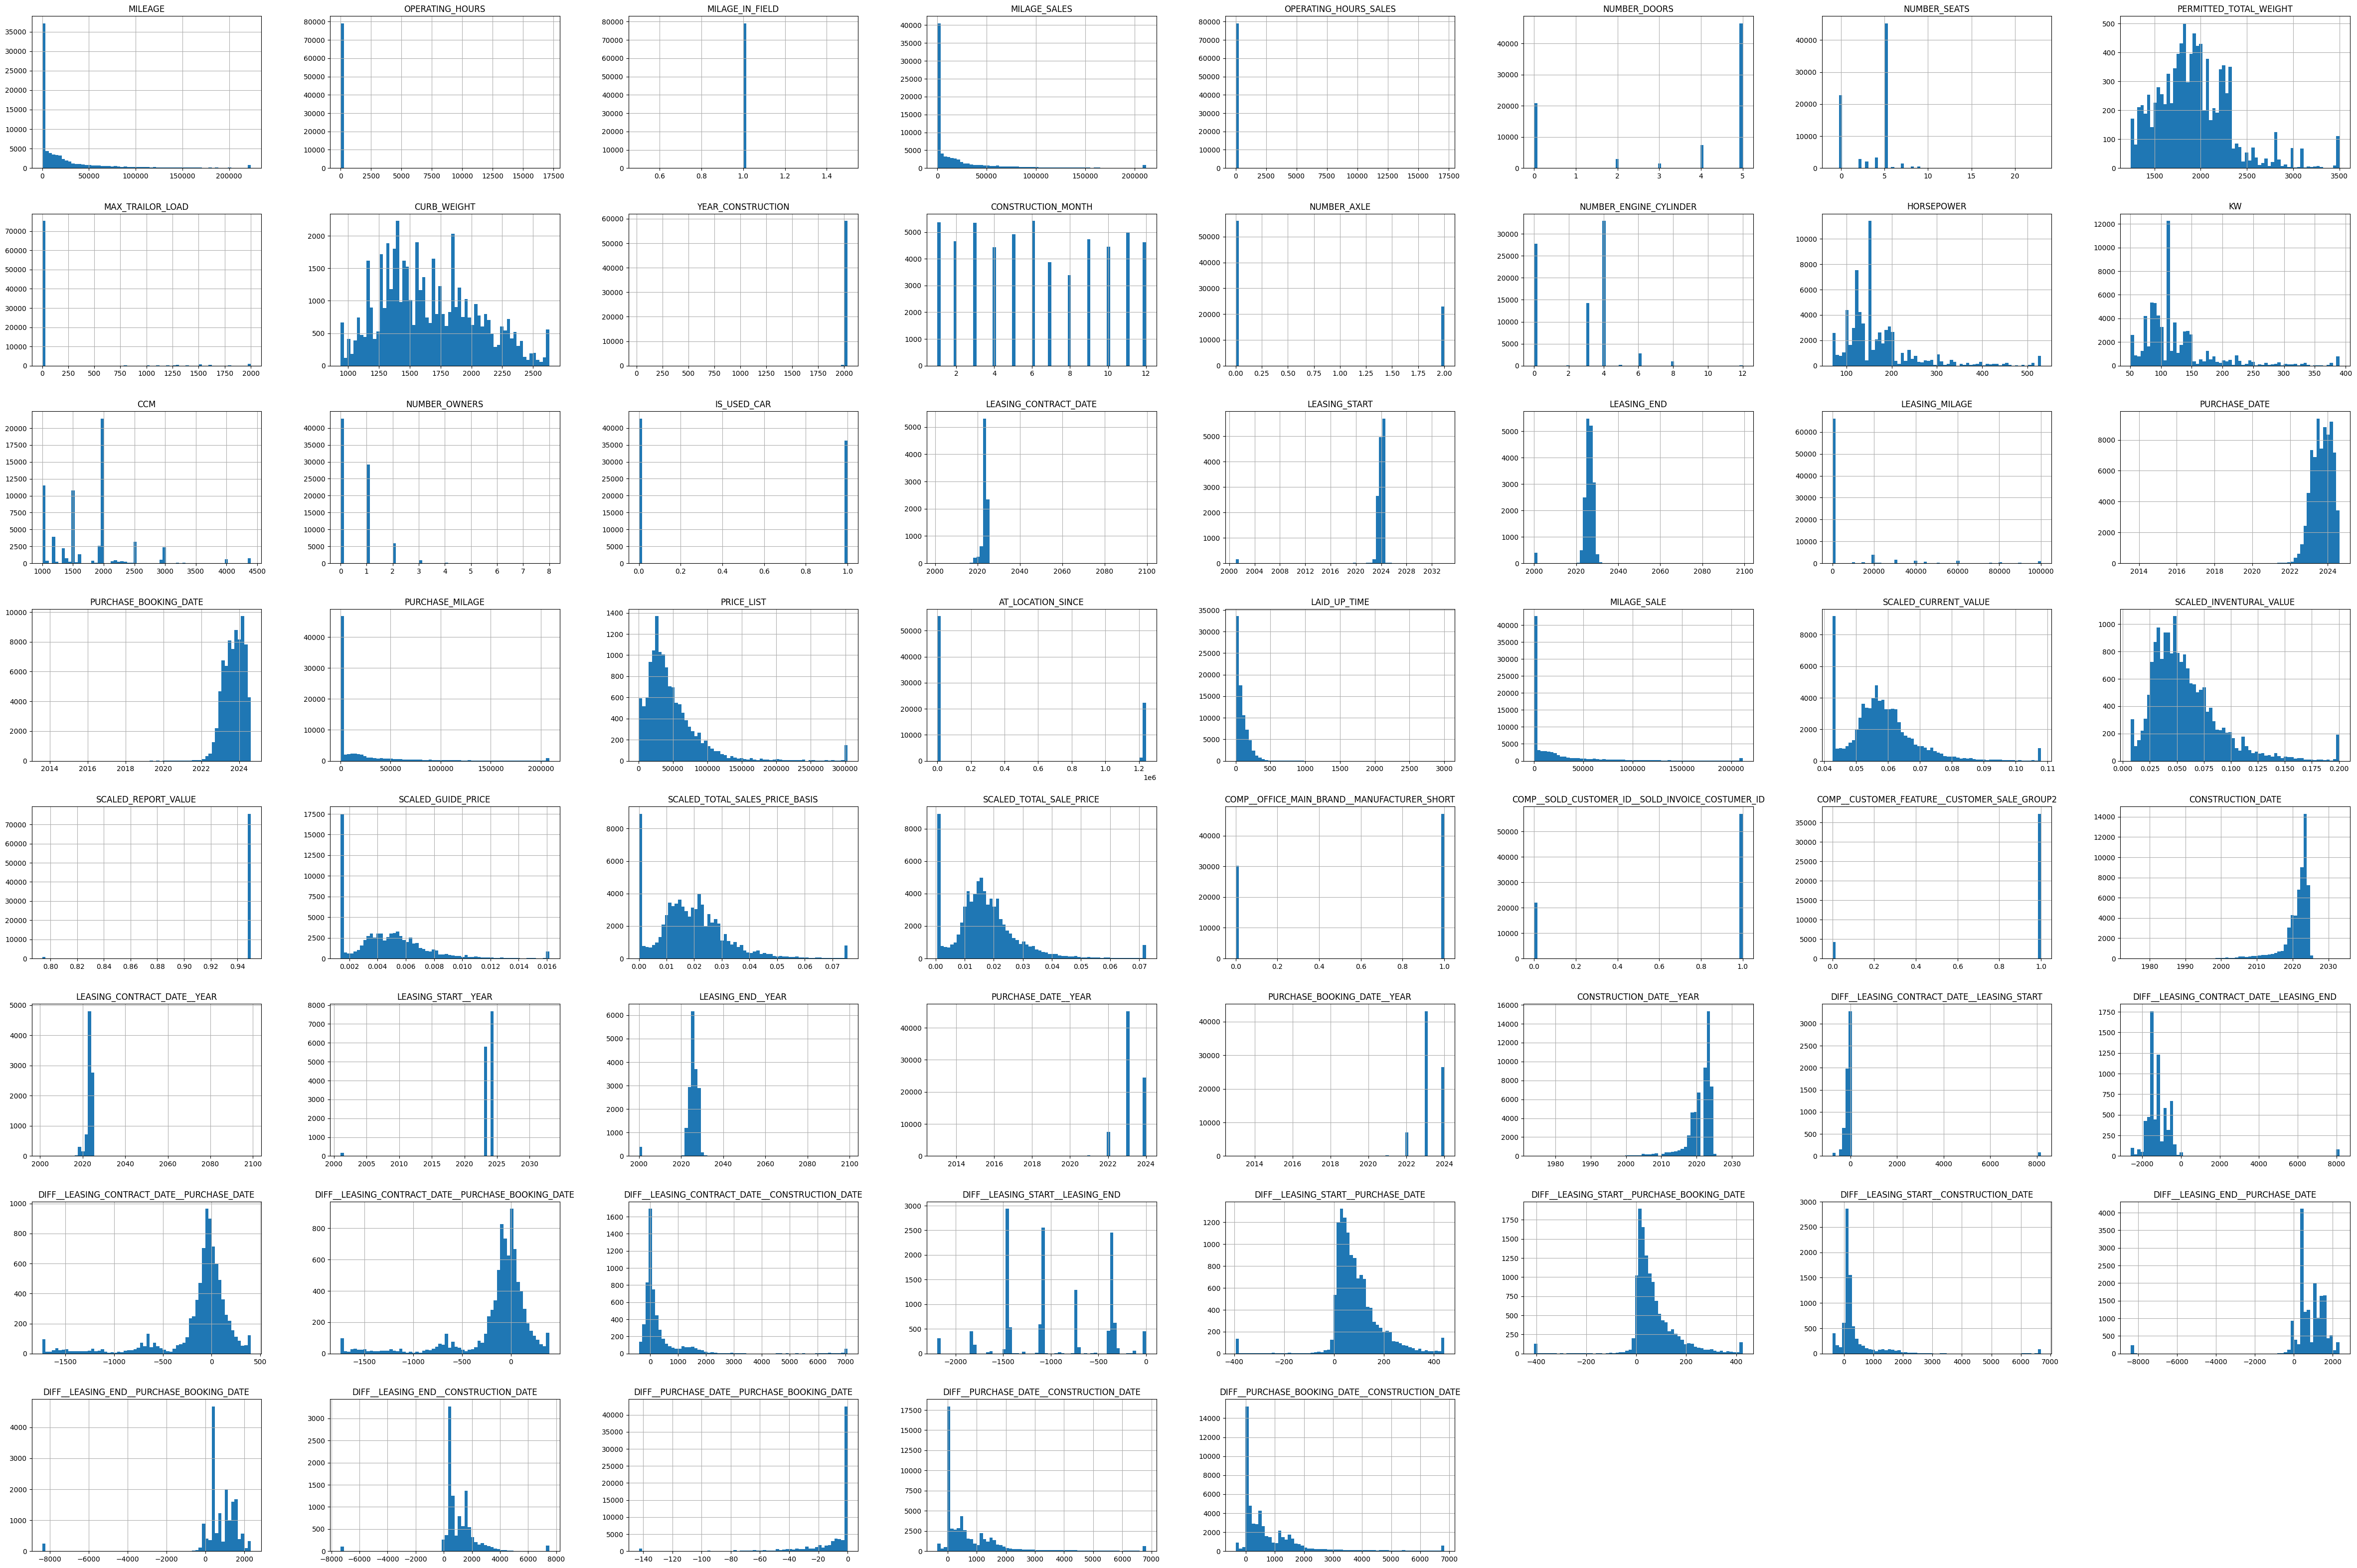

In [743]:
df_train_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

In [744]:
corr_matrix = df_train_train_prep.select_dtypes(include=dtypes["num"]).corr()
print(corr_matrix["LAID_UP_TIME"][corr_matrix["LAID_UP_TIME"].notna()].sort_values(ascending=False))

LAID_UP_TIME                                          1.000000
DIFF__LEASING_START__PURCHASE_DATE                    0.709864
DIFF__LEASING_START__PURCHASE_BOOKING_DATE            0.601654
DIFF__LEASING_CONTRACT_DATE__PURCHASE_DATE            0.164131
DIFF__LEASING_CONTRACT_DATE__PURCHASE_BOOKING_DATE    0.155930
DIFF__LEASING_END__PURCHASE_DATE                      0.138466
DIFF__LEASING_END__PURCHASE_BOOKING_DATE              0.128201
CONSTRUCTION_DATE__YEAR                               0.115616
AT_LOCATION_SINCE                                     0.096517
DIFF__LEASING_START__LEASING_END                      0.096503
LEASING_START__YEAR                                   0.093664
LEASING_END__YEAR                                     0.091148
NUMBER_AXLE                                           0.066776
COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID      0.053607
IS_USED_CAR                                           0.049461
COMP__CUSTOMER_FEATURE__CUSTOMER_SALE_GROUP2          0

### Split features and labels

In [745]:
X_train_train, y_train_train = split_data_frame(df_train_train_prep)
X_train_test, y_train_test = split_data_frame(df_train_test_prep)

### Inspect LAID_UP_TIME

mean: 88.33501517450682
std: 95.79825142064274


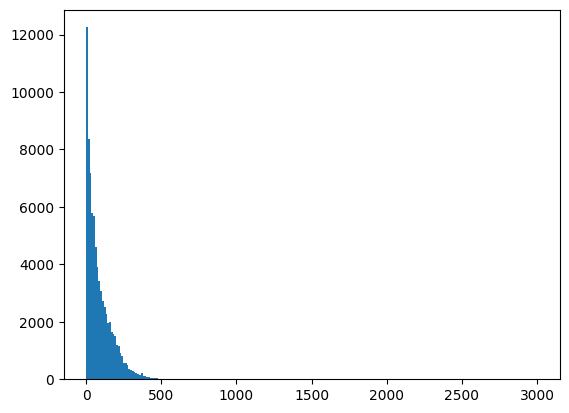

In [746]:
print(f"mean: {np.mean(y_train_train)}")
print(f"std: {np.std(y_train_train)}")
plt.hist(y_train_train, bins=256)
plt.show()

## Preprocessing

### Preprocessing pipeline

In [747]:
def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


def create_preprocessor(
    keep_dates: bool = True,
    keep_nums: bool = True,
    keep_strs: bool = True,
) -> Pipeline:
    date_transformer = Pipeline([
        ("converter", FunctionTransformer(map_date)),
        ("imputer", SimpleImputer()),
        ("scaler", RobustScaler()),
    ])

    num_transformer = Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", RobustScaler()),
    ])

    str_transformer = Pipeline([
        ("imputer", SimpleImputer(missing_values=pd.NA, strategy="constant", keep_empty_features=True, fill_value="N/A")),
        ("encoder", OneHotEncoder(min_frequency=0.01, handle_unknown="infrequent_if_exist", sparse_output=False)),
    ])

    per_dtype_transformers = []
    if keep_dates:
        per_dtype_transformers.append(\
            ("date", date_transformer, make_column_selector(dtype_include=dtypes["date"])))
    if keep_nums:
        per_dtype_transformers.append(\
            ("num", num_transformer, make_column_selector(dtype_include=dtypes["num"])))
    if keep_strs:
        per_dtype_transformers.append(\
            ("str", str_transformer, make_column_selector(dtype_include=dtypes["str"])))
    
    return Pipeline(
        [
            ("per_dtype", ColumnTransformer(per_dtype_transformers)),
            ("variance_threshold", VarianceThreshold()),
        ]
    )

### Inspect preprocessing pipeline

In [748]:
create_preprocessor()

Pipeline(steps=[('per_dtype',
                 ColumnTransformer(transformers=[('date',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function map_date at 0x0000027AFFBFB380>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027A60C84590>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpu...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 keep_empty_features=True,
                                                                                 missing_values=<NA>,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.01,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000027ACDD33950>)])),
                ('variance_threshold', VarianceThreshold())])

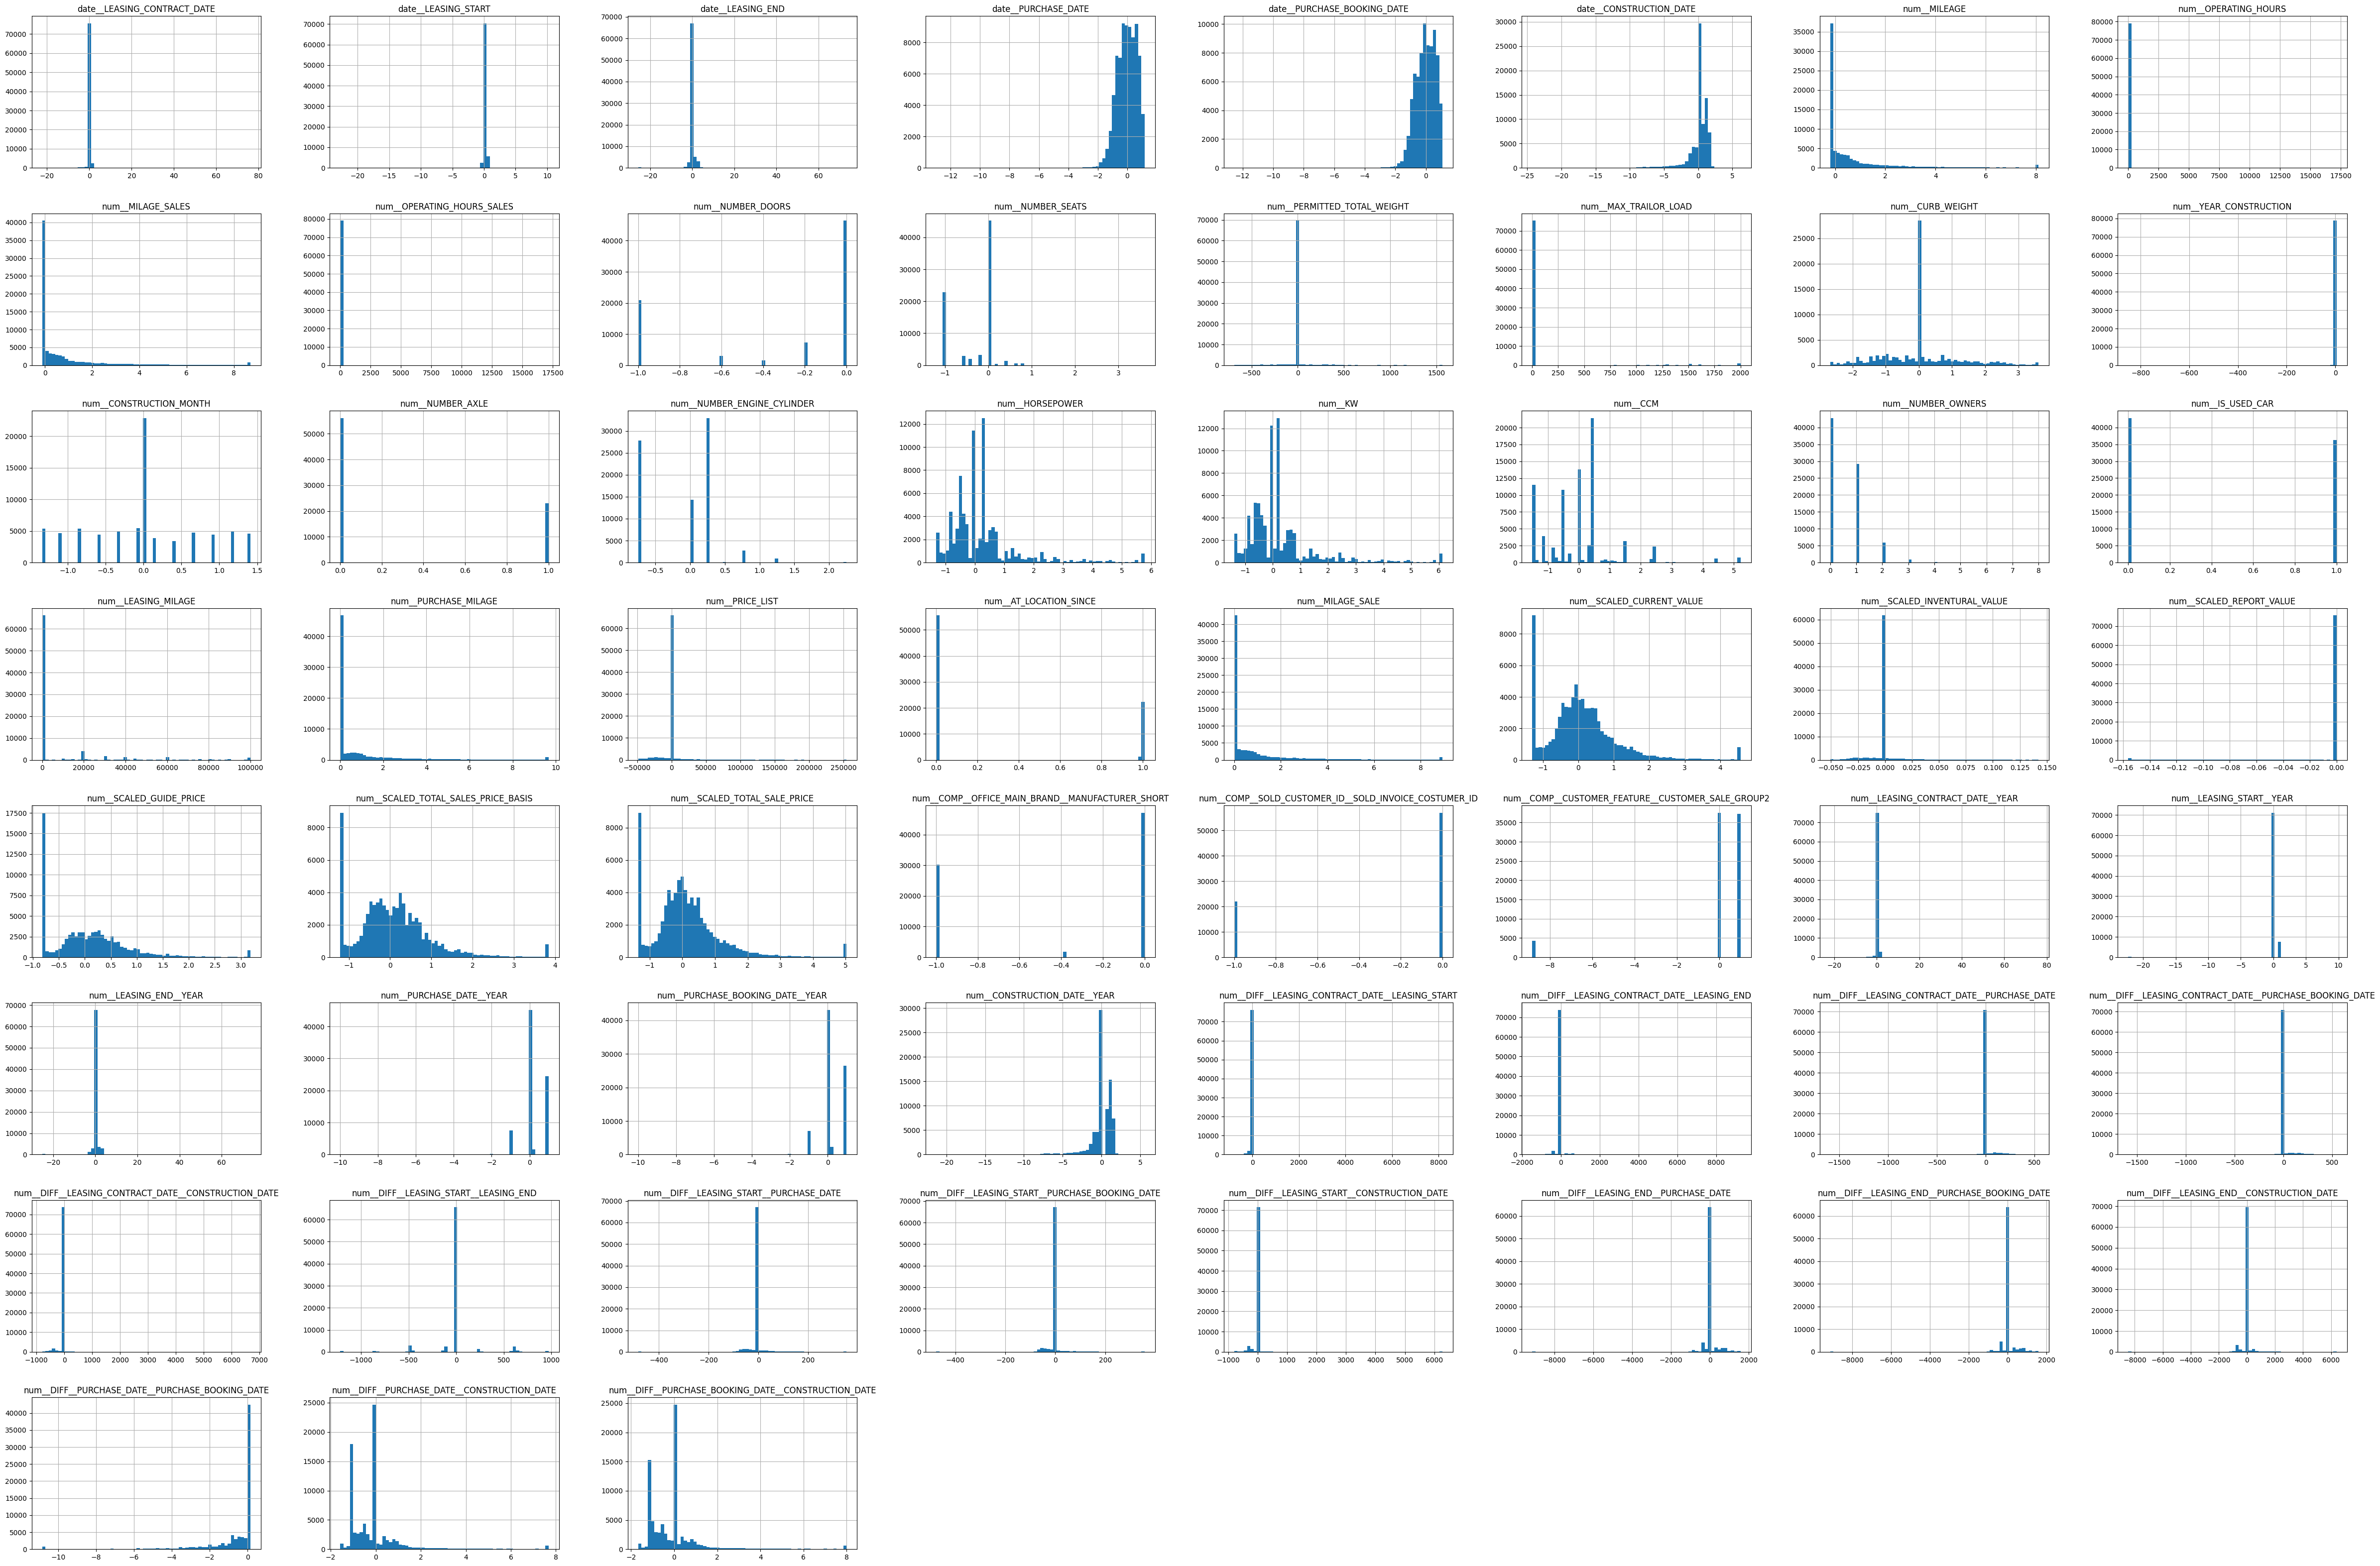

In [749]:
preprocessor = create_preprocessor(keep_strs=False)
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train_train, y_train_train)
X_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

In [750]:
X_train_prep.std().sort_values()

num__SCALED_INVENTURAL_VALUE                                   0.015603
num__SCALED_REPORT_VALUE                                       0.022315
num__NUMBER_DOORS                                              0.431758
num__COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID          0.448291
num__NUMBER_AXLE                                               0.454084
num__AT_LOCATION_SINCE                                         0.458033
num__NUMBER_SEATS                                              0.471283
num__COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT               0.482349
num__IS_USED_CAR                                               0.498298
num__NUMBER_ENGINE_CYLINDER                                    0.507253
date__LEASING_CONTRACT_DATE                                    0.558921
num__LEASING_CONTRACT_DATE__YEAR                               0.566593
num__PURCHASE_DATE__YEAR                                       0.616040
num__PURCHASE_BOOKING_DATE__YEAR                               0

In [751]:
preprocessor = create_preprocessor()
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train_train, y_train_train)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 643 entries, date__LEASING_CONTRACT_DATE to str__CONSTRUCTION_DATE__WEEKDAY_Wednesday
dtypes: float64(643)
memory usage: 388.5 MB


In [752]:
for col in X_train_prep.columns:
    if col.startswith("str__COLOR"):
        print(col)

str__COLOR_CODE_149
str__COLOR_CODE_197
str__COLOR_CODE_2T2T
str__COLOR_CODE_40
str__COLOR_CODE_717
str__COLOR_CODE_N/A
str__COLOR_CODE_NY4
str__COLOR_CODE_PN3GZ
str__COLOR_CODE_PN4DQ
str__COLOR_CODE_PN4GM
str__COLOR_CODE_PN4HS
str__COLOR_CODE_PNZJB
str__COLOR_CODE_infrequent_sklearn
str__COLOR_CODE_NAME_METALLIC
str__COLOR_CODE_NAME_N/A
str__COLOR_CODE_NAME_infrequent_sklearn
str__COLOR_N/A
str__COLOR_black
str__COLOR_blue
str__COLOR_green
str__COLOR_grey
str__COLOR_red
str__COLOR_silver
str__COLOR_white
str__COLOR_infrequent_sklearn
str__COLOR_TYPE_1
str__COLOR_TYPE_N/A
str__COLOR_TYPE_infrequent_sklearn


## Model selection

### Helper functions

In [753]:
def validate_model(model: BaseEstimator):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)
    y_pred = model.predict(X_val)
    print("RMSE:", root_mean_squared_error(y_val, y_pred))

In [754]:
def cross_validate_model(model: BaseEstimator):
    scores = cross_val_score(model, X_train_train, y_train_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("RMSE Std:", rmse_scores.std())

In [755]:
def test_model(model: BaseEstimator):
    model.fit(X_train_train, y_train_train)
    y_pred = model.predict(X_train_test)
    print("RMSE:", root_mean_squared_error(y_train_test, y_pred))

### Linear Regression

In [756]:
linear_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectPercentile(f_regression, percentile=10)),
    ("regressor", LinearRegression(n_jobs=-1)),
])
cross_validate_model(linear_reg)

RMSE Scores: [70.30321315 70.98385339 70.41897797 74.18118891 69.87395382]
RMSE Mean: 71.1522374488399
RMSE Std: 1.55534053603509


### Random Forest Regressor

In [757]:
rng = np.random.RandomState(42)
rand_forest_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectPercentile(f_regression, percentile=10)),
    ("regressor", RandomForestRegressor(n_jobs=-1, random_state=rng)),
])
cross_validate_model(rand_forest_reg)

RMSE Scores: [49.64151609 50.86271731 48.4822816  54.99224441 49.90941551]
RMSE Mean: 50.77763498495248
RMSE Std: 2.239794187644911


### Histogram-Based Gradient Boosting Regressor

In [758]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [44.97745019 45.62018591 43.92636674 50.24418452 45.03224281]
RMSE Mean: 45.96008603488893
RMSE Std: 2.2104982392782673


### Select final model

In [759]:
final_model = hist_grad_boost_reg

## Evaluate model on the test set

In [760]:
test_model(final_model)

RMSE: 72.62961098771174


## Train final model on the full data set

In [761]:
df_train_prep = prepare_data_frame(df_train, fit=True, process_labels=True, use_label_threshold=True)
X_train, y_train = split_data_frame(df_train_prep)
final_model.fit(X_train, y_train);

## Load test data frame

In [762]:
df_new = pd.read_excel("data/Vehicles_export_prices_scaled_stud_test_eng.xlsx")

In [763]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42460 entries, 0 to 42459
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(41), object(60)
memory usage: 34.3+ MB


In [764]:
df_new_prep = prepare_data_frame(df_new, fit=False, process_labels=False, use_label_threshold=False)

In [765]:
df_new_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42397 entries, 0 to 42459
Columns: 128 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(55), string(67)
memory usage: 41.7 MB


## Predict test data values

In [766]:
X_new, _ = split_data_frame(df_new_prep)
y_new = final_model.predict(X_new)

## Save predicted test data values

In [767]:
def save_to_xlsx(features: pd.DataFrame, predictions: np.array, filename: str):
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)
    
    df_output = features.copy()
    df_output["LAID_UP_TIME"] = predictions
    df_output[["CHASSIS_NUMBER", "LAID_UP_TIME"]].to_excel(f"{output_dir}/{filename}", index = False)

In [768]:
save_to_xlsx(X_new, y_new, "teamA-model1.xlsx")

Next steps:
- better feature selection (e.g. PCA)
- GridSearch
- Round predictions
- outlier detection
- per feature mapping (to nulls, etc.)